### 首先介绍训练集中12列数据的含义

| 特征 | 意义 | 备注 |
| - | - | - |
| PassengerId | 旅客ID | 这项特征没什么用 |
| Survived | 是否活下来了（1:yes  0:no） | 这是我们测试集要预测的目标值 |
| Pclass | 旅客等级（1 2 3 分别代表不同的等级） |  |
| Name | 名字 |  |
| Sex | 性别 |  |
| Age | 年龄 |  |
| SibSp | 有多少兄弟姐妹/配偶同船 Number of Siblings/Spouses Aboard |  |
| Parch | 有多少父母/子女同船 Number of Parents/Children Aboard |  |
| Ticket | 船票号码 |  |
| Fare | 船票票价 |  |
| Cabin | 所在小屋 |  |
| Embarked | 登船城市 Port of Embarkation | C Q S 分别代表不同的城市 |

In [1]:
# 在正式开始之前，先导入需要用到的库

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from itertools import count
from IPython.display import display, Image

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import os
print(os.listdir("../input"))  # 数据集存放路径

['gender_submission.csv', 'test.csv', 'train.csv']


In [2]:
# 将训练集和测试集放在一起，以便一起对特征进行处理 
# 处理完成之后使用Survived属性可以再次将它们分开

# pandas.contact之后，要记得用reset_index去处理index
dset = pd.concat([pd.read_csv('../input/train.csv'), pd.read_csv('../input/test.csv')])
dset.reset_index(inplace=True, drop=True)
display(dset.head())
print('Number of instances:\n')
# np.isfinite:返回一个判断是否是有穷（非inf，非NaN）的bool型数组
print('\tTrain: {}'.format(len(dset[np.isfinite(dset['Survived'])])))
print('\tTest: {}'.format(len(dset[dset['Survived'].isnull()])))

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


Number of instances:

	Train: 891
	Test: 418


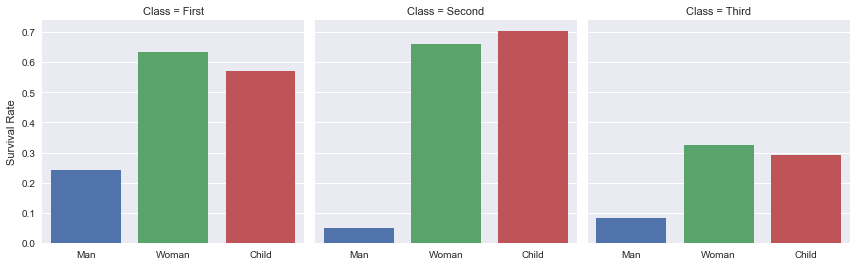

In [3]:
# 通过已知信息，可以尝试猜测哪个特征可能在这个分类问题中起重要作用
# Pclass，Sex和Age是最明显的
# 而不是PassengerId和Embarked

# 下边来绘制三个类别（儿童，妇女，男性）的生存率 
# 为此，暂时创建数据副本并修改其Sex列，此处选择14.5岁作为分类孩子的最大年龄

temp = dset.copy()

# np.where(condition, x, y)，满足条件(condition)，输出x，不满足输出y
temp['Sex'] = np.where(temp['Age'] <= 14.5, 'Child', np.where(temp['Sex'] == 'female', 'Woman', 'Man'))
temp['Pclass'] = temp['Pclass'].map({1: 'First', 2: 'Second', 3: 'Third'})

df_survival_rate = pd.DataFrame({'Category': ['Man', 'Woman', 'Child'] * 3,
                                 'Class': ['First'] * 3 + ['Second'] * 3 + ['Third'] * 3,
                                 'Rate': [0] * 9})

for i in range(len(df_survival_rate)):
    cat, pclass = df_survival_rate.loc[i, ['Category', 'Class']]  # pandas.loc[行标签,列标签]
    # 下边计算生存率
    sub_df = temp[(temp['Sex'] == cat) & (temp['Pclass'] == pclass)]
    sub_df_alive = sub_df[sub_df['Survived'] == 1]
    df_survival_rate.loc[i, 'Rate'] = len(sub_df_alive) / len(sub_df)

f = sns.factorplot('Category', 'Rate', col='Class', data=df_survival_rate, saturation=.9, kind='bar')
_ = f.set_axis_labels('', 'Survival Rate')

del temp  # 用完即删

# 这是一个非常简单的猜测，但现在已经证实：女性和儿童比男性更有优势，一等舱和二等舱乘客也超过了三等舱。

In [4]:
# PassengerId只是分配给每位乘客的号码，可以安全地丢弃这一特征。
dset.drop('PassengerId', axis=1, inplace=True)

In [5]:
# 在分析和处理缺失值之前，先统计哪些特征有缺失值
def count_nan():
    df = []
    for col in dset:
        # col分别取Age、Cabin、Embarked、Fare、Name、Parch、Pclass、Sex、SibSp、Survived、Ticket
        nan = dset[dset[col].isnull()]
        if len(nan):
            perc = round(len(nan) / len(dset), 3) * 100
            df.append((col, len(nan), perc))
    df.sort(key=lambda x: x[2], reverse=True)
    df = pd.DataFrame(df, index=[el[0] for el in df], columns=[0, 'Missing', '%']).drop(0, axis=1)
    display(df)
    
count_nan()

,Missing,%
Cabin,1014,77.5
Survived,418,31.9
Age,263,20.1
Embarked,2,0.2
Fare,1,0.1


In [6]:
# 由于“Cabin”缺失值过多，所以选择丢弃该特征
dset.drop('Cabin', axis=1, inplace=True)
dset.loc[dset['Fare'].isnull(), 'Fare'] = dset['Fare'].mean()  # 缺失值由票价平均值填充
# Embarked登船城市由登船人数较多的港口填充
dset.loc[dset['Embarked'].isnull(), 'Embarked'] = dset['Embarked'].value_counts().index[0]

count_nan()

,Missing,%
Survived,418,31.9
Age,263,20.1


In [7]:
# 此处将“Name”提取城“Surname”和“Title”
dset = pd.concat([dset, dset['Name'].str.extract(r'(?P<Surname>\w+[-]?\w+),\s(?P<Title>\w+)')], axis=1).drop('Name', axis=1)
dset.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title
0,22.0,S,7.2500,0,3,male,1,0.0,A/5 21171,Braund,Mr
1,38.0,C,71.2833,0,1,female,1,1.0,PC 17599,Cumings,Mrs
2,26.0,S,7.9250,0,3,female,0,1.0,STON/O2. 3101282,Heikkinen,Miss
3,35.0,S,53.1000,0,1,female,1,1.0,113803,Futrelle,Mrs
4,35.0,S,8.0500,0,3,male,0,0.0,373450,Allen,Mr


In [8]:
# Now we can fill each NaN in Age with the mean value of the corresponding Title.
info = dset.groupby('Title').describe()['Age']['mean'].sort_values(ascending=False)
display(info)

# 根据‘Title’填充‘Age’
dset.loc[dset['Age'].isnull(), 'Age'] = dset.loc[dset['Age'].isnull(), 'Title'].map(info)
count_nan()

Title
Capt        70.000000
Col         54.000000
Sir         49.000000
Major       48.500000
Lady        48.000000
Dr          43.571429
Rev         41.250000
Don         40.000000
Dona        39.000000
Jonkheer    38.000000
Mrs         36.994118
the         33.000000
Mr          32.252151
Ms          28.000000
Mlle        24.000000
Mme         24.000000
Miss        21.774238
Master       5.482642
Name: mean, dtype: float64

,Missing,%
Survived,418,31.9


In [9]:
dset.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title
0,22.0,S,7.2500,0,3,male,1,0.0,A/5 21171,Braund,Mr
1,38.0,C,71.2833,0,1,female,1,1.0,PC 17599,Cumings,Mrs
2,26.0,S,7.9250,0,3,female,0,1.0,STON/O2. 3101282,Heikkinen,Miss
3,35.0,S,53.1000,0,1,female,1,1.0,113803,Futrelle,Mrs
4,35.0,S,8.0500,0,3,male,0,0.0,373450,Allen,Mr


In [10]:
# 检查一下我们的目标（Survived）和其他特征之间的相关性
# （将性别转换为数字特征，为女性分配值1，为男性分配0）

def create_corr_mat(df, threshold):
    df2 = df.copy()
    corr_mat = df2.corr().nlargest(500, 'Survived')
    corr_mat = corr_mat[corr_mat.index]
    corr_mat = corr_mat[abs(corr_mat['Survived']) > threshold]
    corr_mat = corr_mat[corr_mat.index]
    return corr_mat

dset['Sex'] = np.where(dset['Sex'] == 'female', 1, 0)
create_corr_mat(dset, 0)

,Survived,Sex,Fare,Parch,SibSp,Age,Pclass
Survived,1.000000,0.543351,0.257307,0.081629,-0.035322,-0.087092,-0.338481
Sex,0.543351,1.000000,0.185484,0.213125,0.109609,-0.082965,-0.124617
Fare,0.257307,0.185484,1.000000,0.221522,0.160224,0.169876,-0.558477
Parch,0.081629,0.213125,0.221522,1.000000,0.373587,-0.138532,0.018322
SibSp,-0.035322,0.109609,0.160224,0.373587,1.000000,-0.220784,0.060832
Age,-0.087092,-0.082965,0.169876,-0.138532,-0.220784,1.000000,-0.377708
Pclass,-0.338481,-0.124617,-0.558477,0.018322,0.060832,-0.377708,1.000000


- （**Survived**）和（**Sex**）有很强的正线性相关性，可以理解，女性的生存率比男性的高
- （**Survived**）和（**Fare**）也有正线性相关性，这意味着票价越高，生存机会越高。这是有道理的，因为最昂贵的门票是由属于一等舱和二等舱的富人购买的
- （**Survived**）和（**Pclass**）有较高的负线性相关性，这意味着（**Pclass**）越大，生存机会越低，这从前边所展示的“生存率和等级”那三张图也可以看出来。但是那三张条形图也向我们表明，一等和二等的乘客之间没有明显的区别。事实上，二等舱女性和儿童的生存率似乎与一等舱女性和儿童的生存率相当甚至更高。这可能会误导算法，所以决定将Pclass转换为分类特征，稍后会看到具体的步骤
- （**Survived**）和（**Parch**）、（**SibSp**）、（**Age**）没有很高的线性相关性。（**Survived**）和（**Age**）之间的关系很奇怪，因为我们直观上生存率和年龄是有关系的。仔细想想不难理解，在轮船撞上冰山之后，大家只关心你是不是孩子，而不会在意你具体多少岁，对于30岁和50岁的人是一视同仁的，所以下边会将年龄处理成二类数值来代表是孩子还是成人

In [11]:
dset['Pclass'] = dset['Pclass'].map({1: 'First', 2: 'Second', 3: 'Third'})

child_max = dset.groupby('Title').describe().loc['Master']['Age', 'max']
dset['Age'] = np.where(dset['Age'] <= child_max, 1, 0)

dset.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title
0,0,S,7.2500,0,Third,0,1,0.0,A/5 21171,Braund,Mr
1,0,C,71.2833,0,First,1,1,1.0,PC 17599,Cumings,Mrs
2,0,S,7.9250,0,Third,1,0,1.0,STON/O2. 3101282,Heikkinen,Miss
3,0,S,53.1000,0,First,1,1,1.0,113803,Futrelle,Mrs
4,0,S,8.0500,0,Third,0,0,0.0,373450,Allen,Mr


In [12]:
dset['Age'].groupby(dset['Title']).mean()

Title
Capt        0.000000
Col         0.000000
Don         0.000000
Dona        0.000000
Dr          0.000000
Jonkheer    0.000000
Lady        0.000000
Major       0.000000
Master      1.000000
Miss        0.192308
Mlle        0.000000
Mme         0.000000
Mr          0.006605
Mrs         0.005076
Ms          0.000000
Rev         0.000000
Sir         0.000000
the         0.000000
Name: Age, dtype: float64

In [13]:
dset.loc[(dset['Sex'] == 0) & (dset['Age'] == 1), 'Title'] = 'Master'
dset.loc[(dset['Sex'] == 1) & (dset['Age'] == 1), 'Title'] = 'Miss'

dset['Age'].groupby(dset['Title']).mean()

Title
Capt        0.000000
Col         0.000000
Don         0.000000
Dona        0.000000
Dr          0.000000
Jonkheer    0.000000
Lady        0.000000
Major       0.000000
Master      1.000000
Miss        0.195402
Mlle        0.000000
Mme         0.000000
Mr          0.000000
Mrs         0.000000
Ms          0.000000
Rev         0.000000
Sir         0.000000
the         0.000000
Name: Age, dtype: float64

**Now we create the FamSize feature and drop SibSp and Parch.**

In [14]:
dset['FamSize'] = dset['SibSp'] + dset['Parch'] + 1
dset.drop(['SibSp', 'Parch'], axis=1, inplace=True)

create_corr_mat(dset, 0)

,Survived,Sex,Fare,Age,FamSize
Survived,1.000000,0.543351,0.257307,0.123947,0.016639
Sex,0.543351,1.000000,0.185484,0.052280,0.188583
Fare,0.257307,0.185484,1.000000,-0.006153,0.226465
Age,0.123947,0.052280,-0.006153,1.000000,0.427256
FamSize,0.016639,0.188583,0.226465,0.427256,1.000000


- 可以看到（**Survived**）和（**Age**）的线性相关性增加了
- 但是，（**FamSize**）的pearson相关系数比（**SibSp**）和（**Parch**）都低

In [15]:
# 对乘客按家庭进行分组，使用FamCode来进行标识

c = count(1)

dset['FamCode'] = 0
# To isolate families, we first group passengers by Ticket and Surname and then assign the code
families = dset.groupby(['Ticket', 'Surname'])
for i, f in families:
    dset.loc[f.index, 'FamCode'] = next(c)

dset.head()

,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,Surname,Title,FamSize,FamCode
0,0,S,7.2500,Third,0,0.0,A/5 21171,Braund,Mr,2,779
1,0,C,71.2833,First,1,1.0,PC 17599,Cumings,Mrs,2,895
2,0,S,7.9250,Third,1,1.0,STON/O2. 3101282,Heikkinen,Miss,1,1010
3,0,S,53.1000,First,1,1.0,113803,Futrelle,Mrs,2,78
4,0,S,8.0500,Third,0,0.0,373450,Allen,Mr,1,705


Cool! Now we know which passenger belongs to which family.

**WRONG**! There is a problem, as always. Let's have a closer look at the code below and see what it's doing. The goal is to find errors in the assignment of the **FamCode** we just did. To do that we are basically saying:

1. Consider only the passengers with AT LEAST 1 more person in the family and group them by **FamCode**. This means considering all those passengers who have **FamSize** > 1.

2. Good! Now take the family and check its length. If the **FamCode** assignment is done the right way there MUST be NO family with length equal to 1 because don't forget point 1 in this list: we want only the passengers with **FamSize** > 1.

3. Now my dear little code, if you find (and you shouldn't) any family with just one person please show it to me so I can check what is wrong with it.

4. To avoid very long outputs just show me the first 3 errors, for the rest just keep counting them

5. Thanks!

In [16]:
counter = 0
for i, f in dset[dset['FamSize'] > 1].groupby('FamCode'):
    if len(f) == 1 and counter < 3:
        display(f)
        counter += 1
    elif len(f) == 1 and counter >= 3:
        counter += 1
        
print('There are {} instances that need to be corrected.'.format(counter))

,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,Surname,Title,FamSize,FamCode
1196,0,S,26.55,First,1,NaN,112901,Crosby,Mrs,3,30


,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,Surname,Title,FamSize,FamCode
356,0,S,55.0,First,1,1.0,113505,Bowerman,Miss,2,45


,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,Surname,Title,FamSize,FamCode
166,0,S,55.0,First,1,1.0,113505,Chibnall,Mrs,2,46


There are 70 instances that need to be corrected.


And there you go...70 mistakes. Not nice.

What's up with Mrs Crosby? Her family has 3 members but she's the only one with **FamCode** = 30? Where is the trick?

Let's quickly check one thing

In [17]:
dset[dset['Surname'] == 'Crosby']

,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,Surname,Title,FamSize,FamCode
540,0,S,71.00,First,1,1.0,WE/P 5735,Crosby,Miss,3,1024
745,0,S,71.00,First,0,0.0,WE/P 5735,Crosby,Capt,3,1024
1196,0,S,26.55,First,1,NaN,112901,Crosby,Mrs,3,30


Oh, OK now I see the trick: for some reason Mrs Crosby bought a different ticket from the one her husband and daughter did, that's why I missed her before.

Just make this simple correction and we are good to go

In [18]:
dset.loc[1196, 'FamCode'] = 1024
dset[dset['Surname'] == 'Crosby']

,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,Surname,Title,FamSize,FamCode
540,0,S,71.00,First,1,1.0,WE/P 5735,Crosby,Miss,3,1024
745,0,S,71.00,First,0,0.0,WE/P 5735,Crosby,Capt,3,1024
1196,0,S,26.55,First,1,NaN,112901,Crosby,Mrs,3,1024


And what about Mrs Chibnall and Miss Bowerman? Well in this case they are mother and daughter with same ticket but different surname.

Let's fix this one too

In [19]:
dset.loc[356, 'FamCode'] = 46
dset[dset['Ticket'] == '113505']

,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,Surname,Title,FamSize,FamCode
166,0,S,55.0,First,1,1.0,113505,Chibnall,Mrs,2,46
356,0,S,55.0,First,1,1.0,113505,Bowerman,Miss,2,46


If you keep analyzing all the 70 mistakes you will see that they are just more examples of the same situations: either they have different ticket for some reason or differnt surname.

By googling the passengers involved you would be able to keep track of their actual families and correct the mistakes one by one.

Good news: I did that for you.

Run the code below to reassign the right **FamCode** to the right passenger

In [20]:
families = {'0': 484, '68': 509, '104': 382, '113': 731, '136': 83, '145': 825, '175': 615, '192': 607, '267': 486,
            '352': 317, '356': 46, '371': 378, '392': 382, '417': 268, '442': 753, '451': 738, '496': 682, '529': 369,
            '532': 317, '539': 119, '556': 871, '593': 648, '627': 113, '689': 229, '704': 596, '765': 113,
            '880': 182, '892': 369, '909': 1008, '912': 733, '925': 112, '968': 91, '1012': 664, '1024': 279,
            '1041': 90, '1075': 927, '1078': 772, '1111': 959, '1129': 266, '1196': 1024, '1247': 91, '1261': 350,
            '1267': 413, '1295': 908}

for i in families:
    dset.loc[int(i), 'FamCode'] = families[i]

Perfect, one less problem to solve. Short note: sometimes it is very hard to follow the actual relation between passengers. I did my best to do it correctly but don't be surprised in case you find any mistake.

During the whole process of looking for the right family for each passenger I also saw that in some cases **SibSp** or **Parch** or both contain wrong values, which causes wrong **FamSize** values as a consequence.

To assign the correct value to **FamSize** run the code below

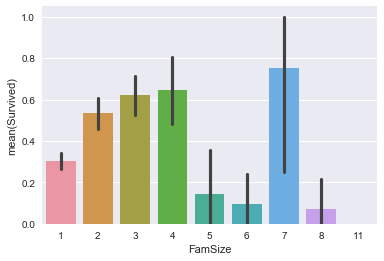

In [21]:
for i, f in dset.groupby('FamCode'):
    dset.loc[f.index, 'FamSize'] = len(f)
    
# At this point we are ready to check the survival rate as a function of FamSize
_ = sns.barplot(dset['FamSize'], dset['Survived'])

Well, we actually see a little trend here.

People with no family (**FamSize** = 1) have less chances to survive than the others, at least until **FamSize** = 4.

For **FamSize** > 4 the survival rate drops drastically (a part from **FamSize** = 7) and the uncertainty intervals are very large for some reason. Probably most of the big families come from the 3rd class and this cause the rate do be very low.

Based on this analysis, let's divide the feature **FamSize** into three categories:

- None, **FamSize** = 1
- Small, 2 <= **FamSize** <= 4
- Big, **FamSize** > 4

In [22]:
dset['FamSize'] = np.where(dset['FamSize'] == 1, 'None', np.where(dset['FamSize'] <= 4, 'Small', 'Big'))

In [23]:
# Remember that FamSize's PCC was even lower than SibSp's and Parch's?
# Check it now
temp = pd.get_dummies(dset, columns=['FamSize'])
display(create_corr_mat(temp, 0))
del temp

,Survived,Sex,FamSize_Small,Fare,Age,FamSize_Big,FamCode,FamSize_None
Survived,1.000000,0.543351,0.282498,0.257307,0.123947,-0.138411,-0.160256,-0.201376
Sex,0.543351,1.000000,0.262682,0.185484,0.052280,0.068965,-0.019370,-0.287558
FamSize_Small,0.282498,0.262682,1.000000,0.195444,0.185399,-0.181883,-0.079977,-0.880181
Fare,0.257307,0.185484,0.195444,1.000000,-0.006153,0.178740,-0.014547,-0.275460
Age,0.123947,0.052280,0.185399,-0.006153,1.000000,0.339674,0.018785,-0.343418
FamSize_Big,-0.138411,0.068965,-0.181883,0.178740,0.339674,1.000000,0.109664,-0.306631
FamCode,-0.160256,-0.019370,-0.079977,-0.014547,0.018785,0.109664,1.000000,0.024481
FamSize_None,-0.201376,-0.287558,-0.880181,-0.275460,-0.343418,-0.306631,0.024481,1.000000


Now the feature starts to gain importance, especially the categories Small and None. That should help the algorithm in making better predictions.

Now it is time to add the last new feature to our dataset. We'll call it **FamAlive** and it is the fraction of family members who survived: 


$$FamAlive=\frac{\quad members \quad of \quad the \quad family \quad who \quad survived \quad}{members \quad of \quad the \quad family}$$

In [24]:
dset['FamAlive'] = 0
families = dset[dset['FamSize'] != 'None'].groupby(['FamCode'])

for i, f in families:

    fam_al = f[f['Survived'] == 1]
    dset.loc[f.index, 'FamAlive'] = len(fam_al) / len(f)
     
display(create_corr_mat(dset, 0))

,Survived,Sex,FamAlive,Fare,Age,FamCode
Survived,1.000000,0.543351,0.504993,0.257307,0.123947,-0.160256
Sex,0.543351,1.000000,0.270466,0.185484,0.052280,-0.019370
FamAlive,0.504993,0.270466,1.000000,0.244390,0.229148,-0.147454
Fare,0.257307,0.185484,0.244390,1.000000,-0.006153,-0.014547
Age,0.123947,0.052280,0.229148,-0.006153,1.000000,0.018785
FamCode,-0.160256,-0.019370,-0.147454,-0.014547,0.018785,1.000000


So the new feature has a strong correlation with the target...good, that's what we wanted.

Now we can finally create our final dataframe which will be used for the predictions.

To do that we need to choose which categorical features we want to use.

In [25]:
dset.head()

,Age,Embarked,Fare,Pclass,Sex,Survived,Ticket,Surname,Title,FamSize,FamCode,FamAlive
0,0,S,7.2500,Third,0,0.0,A/5 21171,Braund,Mr,Small,484,0.0
1,0,C,71.2833,First,1,1.0,PC 17599,Cumings,Mrs,Small,895,0.5
2,0,S,7.9250,Third,1,1.0,STON/O2. 3101282,Heikkinen,Miss,None,1010,0.0
3,0,S,53.1000,First,1,1.0,113803,Futrelle,Mrs,Small,78,0.5
4,0,S,8.0500,Third,0,0.0,373450,Allen,Mr,None,705,0.0


- **Ticket**: not needed, we used already its infomation.
- **Embarked**: I would say it does not matter where passengers boarded Titanic but we'll keep it to be sure.
- **Surname**: not needed, it was useful to extract family informations.
- **Title**: this might be useful.
- **FamSize**: we already saw it's an important feature.

Among numerical features, **FamCode** can also be removed because it's just an identifier assigned by us.

In [26]:
dset.drop(['Ticket', 'Surname', 'FamCode'], axis=1, inplace=True)

Now it's time to select the features (between all the dummies) that we actually want to use. This filter operation is done by selecting a threshold in the create_corr_mat function we created previously. For the moment we set it to be 0.1.

In [27]:
final_df = pd.get_dummies(dset)
corr_mat = create_corr_mat(final_df, 0.1)  # 阈值设为 0.1
corr_mat

,Survived,Sex,FamAlive,Title_Mrs,Title_Miss,Pclass_First,FamSize_Small,Fare,Embarked_C,Age,FamSize_Big,Embarked_S,FamSize_None,Pclass_Third,Title_Mr
Survived,1.000000,0.543351,0.504993,0.336074,0.329948,0.285904,0.282498,0.257307,0.168240,0.123947,-0.138411,-0.149683,-0.201376,-0.322308,-0.543225
Sex,0.543351,1.000000,0.270466,0.564419,0.671213,0.107371,0.262682,0.185484,0.066564,0.052280,0.068965,-0.115193,-0.287558,-0.116562,-0.863894
FamAlive,0.504993,0.270466,1.000000,0.304109,0.054273,0.224856,0.659618,0.244390,0.134890,0.229148,-0.033218,-0.057436,-0.622459,-0.270754,-0.323728
Title_Mrs,0.336074,0.564419,0.304109,1.000000,-0.209421,0.142214,0.377816,0.140937,0.092982,-0.131473,0.002902,-0.014738,-0.367117,-0.176866,-0.487598
Title_Miss,0.329948,0.671213,0.054273,-0.209421,1.000000,-0.019526,-0.014200,0.090133,-0.018122,0.185456,0.084388,-0.111130,-0.026988,0.033130,-0.579857
Pclass_First,0.285904,0.107371,0.224856,0.142214,-0.019526,1.000000,0.161283,0.599956,0.325722,-0.135838,-0.061731,-0.181800,-0.126321,-0.622172,-0.095184
FamSize_Small,0.282498,0.262682,0.659618,0.377816,-0.014200,0.161283,1.000000,0.195444,0.144720,0.185399,-0.181883,-0.046334,-0.880181,-0.223479,-0.299262
Fare,0.257307,0.185484,0.244390,0.140937,0.090133,0.599956,0.195444,1.000000,0.286241,-0.006153,0.178740,-0.169894,-0.275460,-0.419616,-0.192355
Embarked_C,0.168240,0.066564,0.134890,0.092982,-0.018122,0.325722,0.144720,0.286241,1.000000,0.005738,-0.088440,-0.778262,-0.097396,-0.171430,-0.065341
Age,0.123947,0.052280,0.229148,-0.131473,0.185456,-0.135838,0.185399,-0.006153,0.005738,1.000000,0.339674,0.029951,-0.343418,0.105488,-0.364029


As expected, female and male titles have high and low PCC, respectively. Differently from what I was expecting, **Embarked** actually shows some correlation with the target.

At this point we reduce the final df to have only those features we see above and print their number, for the sake of information.

In [28]:
final_df = final_df[corr_mat.index]
print('Number of features used: {}'.format(len(final_df.columns)))

Number of features used: 15


Now we can finally separate train and test set.

In [29]:
def get_sets(df):

    xtrain = df[np.isfinite(df['Survived'])].copy()
    ytrain = xtrain['Survived'].copy()
    xtrain.drop('Survived', axis=1, inplace=True)
    xtest = df[df['Survived'].isnull()].copy()
    xtest.drop('Survived', axis=1, inplace=True)
    xtest.reset_index(inplace=True, drop=True)
    
    cols = xtrain.columns
    scaler = MinMaxScaler()
    scaler.fit(xtrain)
    xtrain = pd.DataFrame(scaler.transform(xtrain), columns=cols)
    xtest = pd.DataFrame(scaler.transform(xtest), columns=cols)
    
    return xtrain, ytrain, xtest


X_train, y_train, X_test = get_sets(final_df)
print('Train set:')
display(X_train.head())
print('Test set:')
display(X_test.head())

Train set:


,Sex,FamAlive,Title_Mrs,Title_Miss,Pclass_First,FamSize_Small,Fare,Embarked_C,Age,FamSize_Big,Embarked_S,FamSize_None,Pclass_Third,Title_Mr
0,0.0,0.0,0.0,0.0,0.0,1.0,0.014151,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,1.0,0.5,1.0,0.0,1.0,1.0,0.139136,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.015469,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,1.0,0.5,1.0,0.0,1.0,1.0,0.103644,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.015713,0.0,0.0,0.0,1.0,1.0,1.0,1.0


Test set:


,Sex,FamAlive,Title_Mrs,Title_Miss,Pclass_First,FamSize_Small,Fare,Embarked_C,Age,FamSize_Big,Embarked_S,FamSize_None,Pclass_Third,Title_Mr
0,0.0,0.00,0.0,0.0,0.0,0.0,0.015282,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,1.0,0.25,1.0,0.0,0.0,1.0,0.013663,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.00,0.0,0.0,0.0,0.0,0.018909,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.00,0.0,0.0,0.0,0.0,0.016908,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,0.50,1.0,0.0,0.0,1.0,0.023984,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Next let's run a grid search for Logistic Regression and use the best model to make the predictions

In [30]:
def run_grid_search():

    lr_values = {
                 'C': [i for i in np.arange(0.1, 1, 0.1)],
                 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
                 }

    lr = LogisticRegression(max_iter=1000)
    gs = GridSearchCV(lr, param_grid=lr_values, scoring='accuracy', return_train_score=True).fit(X_train, y_train)
    print(gs.best_params_)
    print('Mean train score: {}'.format(round(gs.cv_results_['mean_train_score'].mean(), 3)))
    print('Mean test score: {}'.format(round(gs.cv_results_['mean_test_score'].mean(), 3)))
    
    return gs.best_estimator_


best_model = run_grid_search()
preds = best_model.predict(X_test)

# To save the .csv file for submission

# csv_to_submit = np.column_stack((range(892, 1310), preds))
# np.savetxt(path_where_you_want_to_save_it, csv_to_submit, delimiter=',', header='PassengerId,Survived',
#            fmt='%i,%i', comments='')

{'C': 0.80000000000000004, 'solver': 'newton-cg'}
Mean train score: 0.865
Mean test score: 0.859


At this stage we are already able to reach more than 80% accuracy (0.80382), which is a good result. Looking at the difference between the scores from GridSearch and the one from submission, I thought that maybe we are using too many features and this might cause overfitting.

So the next step consists in increasing the PCC threshold from 0.1 to 0.2. In this way we will only include those features whose PCC with the target is AT LEAST equal to 0.2.

Comparing with the previous correlation matrix we are basically excluding:

- **Embarked_C**
- **Age**
- **FamSize_Big**
- **Embarked_S**

In [31]:
final_df = pd.get_dummies(dset)
corr_mat = create_corr_mat(final_df, 0.2)
display(corr_mat)
final_df = final_df[corr_mat.index]
print('Number of features used: {}'.format(len(final_df.columns)))
X_train, y_train, X_test = get_sets(final_df)

best_model = run_grid_search()
preds = best_model.predict(X_test)

,Survived,Sex,FamAlive,Title_Mrs,Title_Miss,Pclass_First,FamSize_Small,Fare,FamSize_None,Pclass_Third,Title_Mr
Survived,1.000000,0.543351,0.504993,0.336074,0.329948,0.285904,0.282498,0.257307,-0.201376,-0.322308,-0.543225
Sex,0.543351,1.000000,0.270466,0.564419,0.671213,0.107371,0.262682,0.185484,-0.287558,-0.116562,-0.863894
FamAlive,0.504993,0.270466,1.000000,0.304109,0.054273,0.224856,0.659618,0.244390,-0.622459,-0.270754,-0.323728
Title_Mrs,0.336074,0.564419,0.304109,1.000000,-0.209421,0.142214,0.377816,0.140937,-0.367117,-0.176866,-0.487598
Title_Miss,0.329948,0.671213,0.054273,-0.209421,1.000000,-0.019526,-0.014200,0.090133,-0.026988,0.033130,-0.579857
Pclass_First,0.285904,0.107371,0.224856,0.142214,-0.019526,1.000000,0.161283,0.599956,-0.126321,-0.622172,-0.095184
FamSize_Small,0.282498,0.262682,0.659618,0.377816,-0.014200,0.161283,1.000000,0.195444,-0.880181,-0.223479,-0.299262
Fare,0.257307,0.185484,0.244390,0.140937,0.090133,0.599956,0.195444,1.000000,-0.275460,-0.419616,-0.192355
FamSize_None,-0.201376,-0.287558,-0.622459,-0.367117,-0.026988,-0.126321,-0.880181,-0.275460,1.000000,0.138938,0.386747
Pclass_Third,-0.322308,-0.116562,-0.270754,-0.176866,0.033130,-0.622172,-0.223479,-0.419616,0.138938,1.000000,0.113778


Number of features used: 11
{'C': 0.80000000000000004, 'solver': 'newton-cg'}
Mean train score: 0.862
Mean test score: 0.861


If you submit at this stage you will score 0.80861. Well it looks like before we were a little bit overfitting the dataset. Now the Mean train score is slighltly lower than before but the submission score increased from 80.4% to 80.9%.

But we are not done yet. It is true that increasing the threshold to 0.2 allowed us to reach higher precision but it is also true that not we are considering the feature **Age** anymore. Following the binarization we did earlier, we lost all the information about a passenger being an adult or a child. It is a big thing we are leaving out and we don't want that.

To solve the problem, let's create a new feature **Category**. This feature classifies the passengers as one of the following three categories: Woman, Man or Child.

In this way we are bringing back the information about the age, hoping that now it will have a PCC higher than 0.2.

In [32]:
dset['Category'] = np.where(dset['Age'] == 1, 'Child', np.where(dset['Sex'] == 1, 'Woman', 'Man'))
final_df = pd.get_dummies(dset)
corr_mat = create_corr_mat(final_df, 0.2)
display(corr_mat)
final_df = final_df[corr_mat.index]
print('Number of features used: {}\n'.format(len(final_df.columns)))
X_train, y_train, X_test = get_sets(final_df)

best_model = run_grid_search()
preds = best_model.predict(X_test)

,Survived,Sex,Category_Woman,FamAlive,Title_Mrs,Title_Miss,Pclass_First,FamSize_Small,Fare,FamSize_None,Pclass_Third,Title_Mr,Category_Man
Survived,1.000000,0.543351,0.516808,0.504993,0.336074,0.329948,0.285904,0.282498,0.257307,-0.201376,-0.322308,-0.543225,-0.560286
Sex,0.543351,1.000000,0.916381,0.270466,0.564419,0.671213,0.107371,0.262682,0.185484,-0.287558,-0.116562,-0.863894,-0.898533
Category_Woman,0.516808,0.916381,1.000000,0.200184,0.615921,0.522897,0.150790,0.202838,0.200304,-0.203945,-0.140953,-0.791656,-0.823398
FamAlive,0.504993,0.270466,0.200184,1.000000,0.304109,0.054273,0.224856,0.659618,0.244390,-0.622459,-0.270754,-0.323728,-0.322753
Title_Mrs,0.336074,0.564419,0.615921,0.304109,1.000000,-0.209421,0.142214,0.377816,0.140937,-0.367117,-0.176866,-0.487598,-0.507149
Title_Miss,0.329948,0.671213,0.522897,0.054273,-0.209421,1.000000,-0.019526,-0.014200,0.090133,-0.026988,0.033130,-0.579857,-0.603107
Pclass_First,0.285904,0.107371,0.150790,0.224856,0.142214,-0.019526,1.000000,0.161283,0.599956,-0.126321,-0.622172,-0.095184,-0.063955
FamSize_Small,0.282498,0.262682,0.202838,0.659618,0.377816,-0.014200,0.161283,1.000000,0.195444,-0.880181,-0.223479,-0.299262,-0.299855
Fare,0.257307,0.185484,0.200304,0.244390,0.140937,0.090133,0.599956,0.195444,1.000000,-0.275460,-0.419616,-0.192355,-0.186191
FamSize_None,-0.201376,-0.287558,-0.203945,-0.622459,-0.367117,-0.026988,-0.126321,-0.880181,-0.275460,1.000000,0.138938,0.386747,0.392689


Number of features used: 13

{'C': 0.30000000000000004, 'solver': 'newton-cg'}
Mean train score: 0.87
Mean test score: 0.868


And it worked! Now Category_Woman and Category_Man have high PCC (> 0.5) and we are able to increase the score by almost 1%. Score with this last prediction is 0.81818.

In [33]:
print(type(X_test))
print(np.shape(X_test))
X_test.head()

<class 'pandas.core.frame.DataFrame'>
(418, 12)


,Sex,Category_Woman,FamAlive,Title_Mrs,Title_Miss,Pclass_First,FamSize_Small,Fare,FamSize_None,Pclass_Third,Title_Mr,Category_Man
0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.015282,1.0,1.0,1.0,1.0
1,1.0,1.0,0.25,1.0,0.0,0.0,1.0,0.013663,0.0,1.0,0.0,0.0
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.018909,1.0,0.0,1.0,1.0
3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.016908,1.0,1.0,1.0,1.0
4,1.0,1.0,0.50,1.0,0.0,0.0,1.0,0.023984,0.0,1.0,0.0,0.0


In [34]:
print(type(preds))
print(np.shape(preds))
print(preds)

<class 'numpy.ndarray'>
(418,)
[ 0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.
  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.  1.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.
  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  1.  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.
  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  1.  1.
  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.
  0.  1.  1.  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  1.  0.
  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  1.  0.  0.  1.  1.  0.  0.
  0.  0.  0.  0.  1.

In [35]:
_X_test = pd.read_csv('../input/test.csv')
_X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [36]:
with open('./preds.csv', 'w') as f:
    f.write('PassengerId,Survived\n')
    for _ in range(418):
        f.write(str(_X_test['PassengerId'][_])+','+str(int(preds[_]))+'\n')

### 好了，现在可以把[preds.csv]文件提交了~